In [8]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np

In [ ]:
from scipy.spatial.distance import cosine
import os
embedding_models = [
    'Cohere_embed-english-v2.0',
    'fastText-en',
    'distilbert-base-uncased',
    'GPTCache/paraphrase-albert-onnx',
    'ada002',
    'PaddlePaddle_ernie-3.0-medium-zh',
    'sgugger/rwkv-430M-pile',
    'google-bert/bert-base-uncased',
    'michiyasunaga/LinkBERT-base',
    'xlnet/xlnet-large-cased',
    'FacebookAI/roberta-base',
    'albert/albert-base-v2',
    'SpanBERT/spanbert-large-cased',
    'google/electra-large-generator',
    'sentence-transformers/all-MiniLM-L6-v2',
    'unum-cloud/uform-vl-english',
    'sentence-transformers/gtr-t5-large',
    'sentence-transformers/sentence-t5-large',
    'sentence-transformers/all-mpnet-base-v2',
    'tiiuae/falcon-7b',
    'kaetemi/falcon-7b-Q4_0-GGUF',
    'baffo32/decapoda-research-llama-7B-hf',
    'NousResearch/Llama-2-7b-hf',
    'leliuga/Llama-2-7b-hf-bnb-4bit']
# word_swap[0.00443972 0.00036407]

metamorphic = ['word_swap', 'obj_sub', 'verb_sub', 'nega_exp', 'word_del', 'num_sub', 'err_translate', 'err_nli']
metrics = ['WS', 'OS', 'AS', 'NE', 'WD', 'QS', 'ET', 'EN']
distance_metrics = ['cosine', 'euclidean', 'person', 'manhattan', 'lancewilliams', 'mahalanobis', 'braycurtis']

def cosine_n(a, b):
  norma = np.linalg.norm(a)
  normb = np.linalg.norm(b)
  if norma == 0 or normb == 0:
    return 1
  return 1 - np.dot(a, b) / (norma * normb)

def euclidean_n(a, b):
    sum_squared_distance = 0
    for p1, p2 in zip(a,b):
        sum_squared_distance += math.pow(p1 - p2, 2)
    return math.sqrt(sum_squared_distance)

def calculate_cov_matrix(embedding_arrays):
    if len(embedding_arrays) < 2:
        raise ValueError("Not enough data to calculate covariance matrix")
    return np.linalg.inv(np.cov(embedding_arrays, rowvar=False))


def calcuate_distance_accuracy(dis_func):
  accd = np.empty((0, 8))
  data = np.empty((0, 16))
  for model_name in embedding_models:
    print('---------'+model_name)
    distance_metric = None
    total_dis = []
    total_dis_detail=[]
    total_acc = []
    for me in metamorphic:
      path = model_name.replace('/', '_') + '_' + me + '.npy'
      if not os.path.exists(path):
        print(path+"notexist")
        total_dis = np.concatenate((total_dis, [1, 1]))
        total_acc = np.concatenate((total_acc, [0]))
        # total_dis_detail = np.concatenate((total_dis_detail, [[0, 0]]))
        continue

      if 'ada' in model_name:
        embedding_arrays = np.load(path, allow_pickle=True)
        for i in range(0, 15000):
          embedding_arrays[i] = embedding_arrays[i].embedding
      else:
        embedding_arrays = np.load(path)[-15000:]
      # np.save(path, embedding_arrays)
      cd_dis = []
      cd_acc = []
      if len(embedding_arrays[0]) == 3:
        embedding_arrays = embedding_arrays.reshape(-1, len(embedding_arrays[0][0]))
      elif len(embedding_arrays[0]) == 1:
        embedding_arrays = embedding_arrays.squeeze(axis=1)
      norms = np.linalg.norm(embedding_arrays, axis=1, keepdims=True)
      close_to_one = np.isclose(norms, 1.0)
      norms[close_to_one] = 1.0
      norms[norms == 0] = 1
      embedding_arrays = embedding_arrays / norms
      matrix_cov = calculate_cov_matrix(embedding_arrays)
      for i in range(5000):
        pos = dis_func(embedding_arrays[3*i], embedding_arrays[3*i+1], matrix_cov)
        neg = dis_func(embedding_arrays[3*i], embedding_arrays[3*i+2], matrix_cov)
        cd_dis.append([pos, neg])
        cd_acc.append(1 if pos < neg else 0)


      total_dis_detail.append(cd_dis)
      mean = np.mean(cd_dis, axis=0)
      print(me + str(mean))
      acc = np.mean(cd_acc)
      total_dis = np.concatenate((total_dis, mean))
      total_acc = np.concatenate((total_acc, [acc]))
      print(total_acc)

    min_distance = np.min(total_dis_detail)
    max_distance = np.max(total_dis_detail)
    normalized_total_dis = (total_dis_detail - min_distance) / (max_distance - min_distance + 1e-8)
    total_dist = [np.mean(d, axis=0).tolist() for d in normalized_total_dis]
    total_dist = np.concatenate(total_dist)
    print(min_distance)
    print(max_distance)
    print(total_dist)
    print(total_dis)
    data = np.concatenate((data , total_dist[np.newaxis, :]), axis=0)
    accd = np.concatenate((accd , total_acc[np.newaxis, :]), axis=0)
  return data, accd


data, accd = calcuate_distance_accuracy(cosine_n)


In [7]:
data=data.round(2)

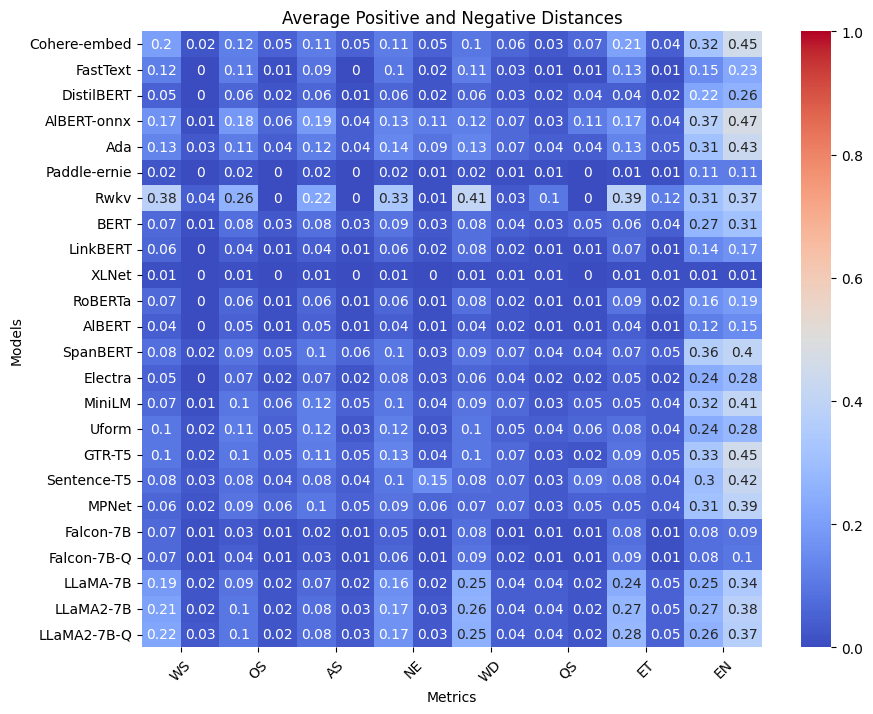

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns



model_names = [
    'Cohere-embed', 'FastText',
    'DistilBERT', 'AlBERT-onnx', 'Ada', 'Paddle-ernie', 'Rwkv', 'BERT', 'LinkBERT', 'XLNet', 'RoBERTa', 'AlBERT',
    'SpanBERT', 'Electra', 'MiniLM', 'Uform', 'GTR-T5', 'Sentence-T5', 'MPNet', 'Falcon-7B', 'Falcon-7B-Q',
    'LLaMA-7B', 'LLaMA2-7B', 'LLaMA2-7B-Q'
]


plt.figure(figsize=(10, 8))
ax = sns.heatmap(data, annot=True, cmap='coolwarm', xticklabels=metrics, yticklabels=model_names, vmin=0, vmax=1)
ax.set_xticks(np.arange(1, len(metrics)*2, 2))
ax.set_xticklabels(metrics, rotation=45)

plt.title('Average Positive and Negative Distances')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()

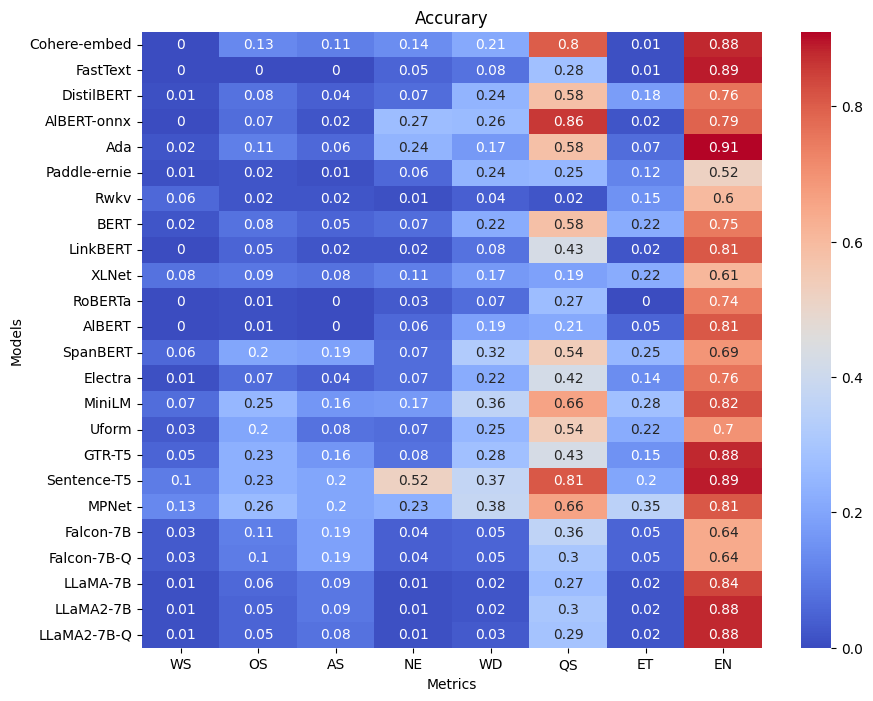

In [10]:
plt.figure(figsize=(10, 8))
accd= accd.round(2)
sns.heatmap(accd, annot=True, cmap='coolwarm', xticklabels=metrics, yticklabels=model_names)


plt.title('Accurary')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()

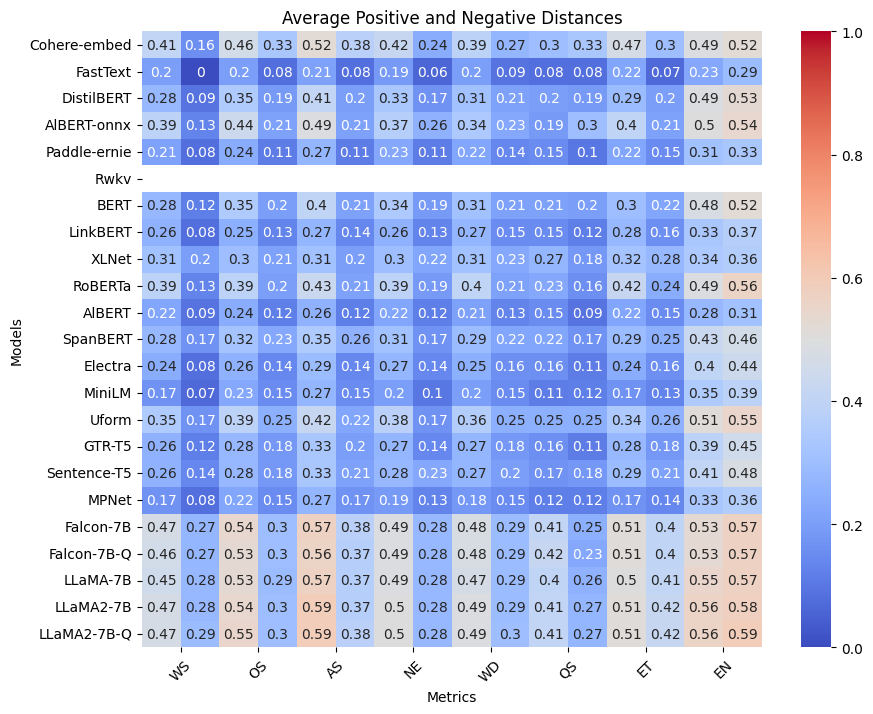

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

data=data.round(2)
model_names = [
    'Cohere-embed', 'FastText',
    'DistilBERT', 'AlBERT-onnx', 'Paddle-ernie', 'Rwkv', 'BERT', 'LinkBERT', 'XLNet', 'RoBERTa', 'AlBERT',
    'SpanBERT', 'Electra', 'MiniLM', 'Uform', 'GTR-T5', 'Sentence-T5', 'MPNet', 'Falcon-7B', 'Falcon-7B-Q',
    'LLaMA-7B', 'LLaMA2-7B', 'LLaMA2-7B-Q'
]


plt.figure(figsize=(10, 8))
ax = sns.heatmap(data, annot=True, cmap='coolwarm', xticklabels=metrics, yticklabels=model_names, vmin=0, vmax=1)
ax.set_xticks(np.arange(1, len(metrics)*2, 2))
ax.set_xticklabels(metrics, rotation=45)

plt.title('Average Positive and Negative Distances')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()

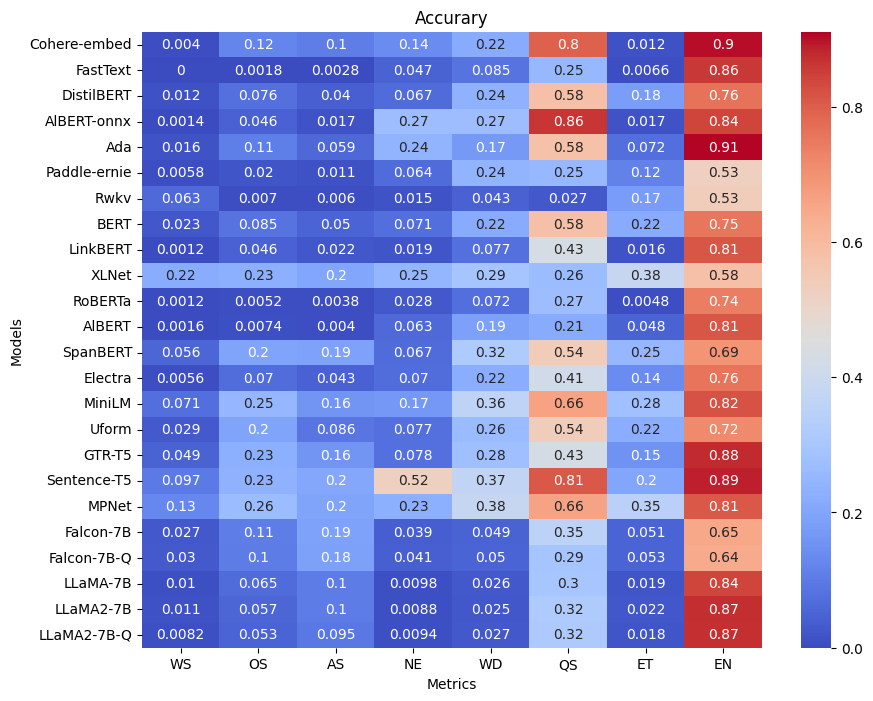

In [19]:
plt.figure(figsize=(10, 8))
accd= accd/100
sns.heatmap(accd, annot=True, cmap='coolwarm', xticklabels=metrics, yticklabels=model_names)


plt.title('Accurary')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()